C:\Users\stoya\AppData\Local\Temp\ipykernel_33720\4049220904.py:145: RuntimeWarning: invalid value encountered in divide
  tmpJ = np.abs((Jl[i]-Jr[i]) / (Jl[i]+Jr[i]))


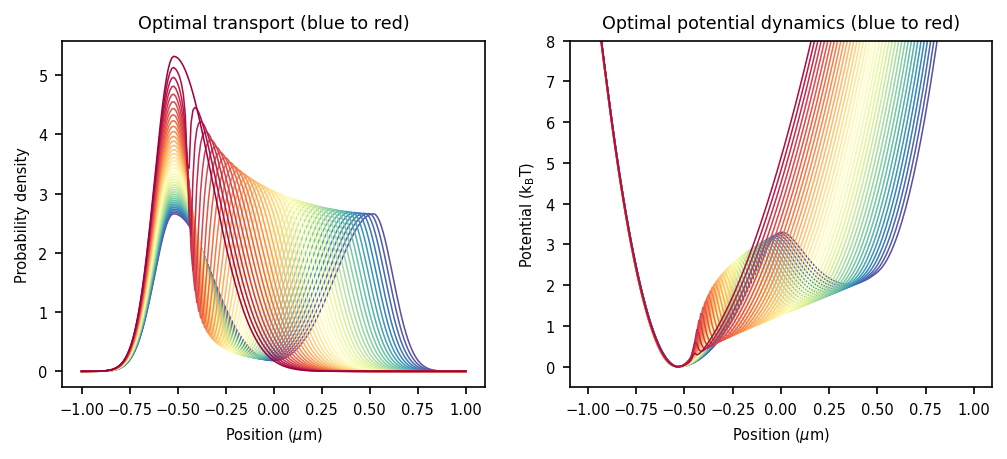

T x (Minimum entropy production) = 1.51 kBT


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import interpolate
import math
import functools
import torch
from ot.lp import wasserstein_1d

T = 273.15 + 25
kBT = T*1.38E-23


def calc_wasserstein(params, distA, distB): 
    maxX = params['maxX']
    
    x = np.linspace(-maxX, maxX, len(distA))    
    x_torch = torch.tensor(x).to()
    
    a_torch = torch.tensor(distA / distA.sum()).to()
    b_torch = torch.tensor(distB / distB.sum()).to()        
        
    W = wasserstein_1d(x_torch, x_torch, a_torch, b_torch, p = 2).item() 
        
    return W

def landauer_P(params):
    x_min, x_max = -5.0, 5.0

    def optimal_map(par0, par1):
        N_cdf_sampling = 0x10000
        N_cdf_tail_sampling = 0x20
        N_bisect = 48
        
        def mixed_asym_gauss_cdf(x, par):
            cdf = 0.0
            for mu, sigma_L, sigma_R, A in par:
                sigma_mean = (sigma_L + sigma_R) / 2
                A_L = sigma_L / sigma_mean * A
                A_R = sigma_R / sigma_mean * A
                if x < mu :
                    cdf += (A_L * math.erf( (x - mu) / (math.sqrt(2) * sigma_L) ) + A_L) / 2
                else:
                    cdf += (A_R * math.erf( (x - mu) / (math.sqrt(2) * sigma_R) ) + A_L) / 2
            return cdf

        def bisect(cdf, val, x_min, x_max):
            x_lower = x_min
            x_upper = x_max
            for _ in range(N):
                x_m = (x_lower + x_upper) / 2
                val_m = cdf(x_m)
                if val == val_m:
                    return x_m
                elif val < val_m:
                    x_upper = x_m
                elif val > val_m:
                    x_lower = x_m
                else:
                    raise
            return (x_lower + x_upper) / 2

        cdf_0 = functools.partial(mixed_asym_gauss_cdf, par=par0)
        cdf_1 = functools.partial(mixed_asym_gauss_cdf, par=par1)

        cdf_min, cdf_max = 0, 1

        map = []
        cdf_linear = [( cdf_min * (N_cdf_sampling - i - 0.5) + cdf_max * (i + 0.5) ) / N_cdf_sampling for i in range (N_cdf_sampling)]
        cdf_array = [cdf_min + (cdf_linear[0] - cdf_min) * 2 ** n for n in range(-N_cdf_tail_sampling, 0)] \
        + cdf_linear \
        + [ cdf_max - (cdf_max - cdf_linear[-1]) * 2 ** (-n) for n in range(1, N_cdf_tail_sampling)]
        for cdf_val in cdf_array:
            x_0 = bisect(cdf_0, cdf_val, x_min, x_max, N_bisect)
            x_1 = bisect(cdf_1, cdf_val, x_min, x_max, N_bisect)
            map.append((cdf_val, x_0, x_1))
            
        return map


    def optimal_snapshots(results, stepN, binN):
        P = []
        fx = np.linspace(-0.5, 0.5, binN)
        for l in np.linspace(0, 1, stepN):
            interpolated = [(cdf_val, x_0 * (1 - l) + x_1 * l) for cdf_val, x_0, x_1 in results]
            sx = [x_min]
            sp = [0]
            for i in range(len(interpolated)-1):
                p = (interpolated[i+1][0] - interpolated[i][0]) / (interpolated[i+1][1] - interpolated[i][1])
                sx.append((interpolated[i+1][1] + interpolated[i][1]) / 2)
                sp.append(p)
                
            sx.append(x_max)
            sp.append(0)            
            
            f = interpolate.PchipInterpolator(sx, sp) 
            P.append(f(fx))
        
        return fx, P
        
    
    sigma_ex, sigma_in = 0.05, 0.1
    delta = 0.26
    params_0 = [ (-delta, sigma_ex, sigma_in, 0.5 ), (delta, sigma_in, sigma_ex, 0.5 ) ]
    params_1 = [ (-delta, sigma_ex, sigma_in, 1), (delta, sigma_in, sigma_ex, 0)]

    xN, maxX = params['xN'], params['maxX']
    
    map = optimal_map(params_0, params_1)
    _, P = optimal_snapshots(map, stepN, xN)
    
    
    x = np.linspace(-maxX, maxX, xN)

    return np.array(x), np.array(P) 



def SolveFokkerPlanck(params, P):
    tau, xN, stepN, maxX, gamma = params['tau'], params['xN'], params['stepN'], params['maxX'], params['gamma']

    dt = tau / (stepN - 1)
    dx = 2*maxX / (xN - 1)

    dPdt = np.array([P[step+1] - P[step] for step in range(stepN - 1)]) / dt

    J, Jl, Jr = np.zeros([stepN-1, xN+1]), np.zeros([stepN-1, xN+1]), np.zeros([stepN-1, xN+1])

    gradP = np.zeros([stepN  , xN-1])
    force = np.zeros([stepN-1, xN-1])

    caldist, calJ, calgradP = np.zeros([stepN-1, xN-1]), np.zeros([stepN-1, xN-1]), np.zeros([stepN-1, xN-1])

    for i in range(stepN-1):         
        for l in range(xN-1):
            Jl[i][l+1] = Jl[i][l] - dPdt[i][l]*dx
            Jr[i][xN-l-1] = Jr[i][xN-l] + dPdt[i][xN-l-1]*dx

        tmpJ = np.abs((Jl[i]-Jr[i]) / (Jl[i]+Jr[i]))
        m = np.argmin(np.nan_to_num(tmpJ, nan = np.inf))
        
        for l in range(xN): 
            if l < m:
                J[i][l] = Jl[i][l]
            elif l > m:
                J[i][l] = Jr[i][l]
            else: # l == m
                J[i][l] = (Jl[i][l]+Jr[i][l])/2
    
    for i in range(stepN-1): 
        for l in range(xN-1):
            caldist[i,l] = (P[i,l]+P[i,l+1]+P[i+1,l]+P[i+1,l+1])/4
            calJ[i,l] = J[i,l+1]

    for i in range(stepN): 
        for l in range(xN-1):
            gradP[i][l] = (P[i,l+1]-P[i,l])/dx
            if i!=0:
                calgradP[i-1][l] = (gradP[i-1][l] + gradP[i][l])/2

    force = -gamma*(calJ + kBT/gamma*calgradP)/caldist 

    U = np.zeros([stepN-1, xN-1])
    for i in range(stepN-1): 
        U[i][0] = force[i][0]*dx
        for l in range(xN-2):
            U[i][l+1] = U[i][l] + force[i][l+1]*dx
        
        U[i] -= np.min(U[i])


    xN, maxX = params['xN'], params['maxX']
    
    x = np.linspace(-maxX, maxX, xN-1, endpoint = False) + 0.5*(2*maxX/(xN-1))

    return x, U


def main():
    
    params = {
        'maxX': 1E-6,  # Maximum value of position [m]
        'xN':201,  # Bin number of position
        'stepN': 41, # Bin number of time
        
        'gamma': 1E12*kBT, # Friction coefficient [kg/(m.s)]

        'tau': 0.2 # Duration of transport [s]
    }

    # Optimal transport dynamics
    x_P, P = landauer_P(params)  

    # Optimal potential dynamics
    x_U, U = SolveFokkerPlanck(params, P)  

    # plot
    _, [ax1, ax2] = plt.subplots(1, 2, figsize = (8, 3), dpi = 150)  

    for i in range(len(P)):
        ax1.plot(x_P*1E6, P[i],  color = cm.Spectral_r(i/len(U)), linewidth = 0.75)
        
    ax1.set_title("Optimal transport (blue to red)")
    ax1.set_xlabel(r'Position ($\mu$m)')
    ax1.set_ylabel('Probability density')


    for i in range(len(U)):
        ax2.plot(x_U*1E6, U[i]/kBT, color = cm.Spectral_r(i/len(U)), linewidth = 0.75)

    ax2.set_title("Optimal potential dynamics (blue to red)")
    ax2.set_ylim([-0.5, 8])
    ax2.set_xlabel(r'Position ($\mu$m)')
    ax2.set_ylabel(r'Potential ($\mathrm{k_\mathrm{B}T}$)')

    plt.show()
        
        
    # Calc the minimum entropy production
    
    W = calc_wasserstein(params, P[0], P[-1])
    
    tau, gamma = params['tau'], params['gamma']  
    EP_min = W / (tau*T/gamma)        
        
    print(f'T x (Minimum entropy production) = {T * EP_min / kBT:.3} kBT')
    
    
if __name__ == "__main__":
    main()